In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
#from tensorflow import keras
#Используем костыль для исправления IntelliSense для keras по гайду:
#https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2
import keras.api._v2.keras as keras
from keras import layers
from keras import losses
from keras.datasets import mnist
import numpy as np
from emnist import list_datasets
from emnist import extract_training_samples

In [2]:
(x_train,y_train), (x_test,y_test)=mnist.load_data()

x_train, y_train = extract_training_samples('byclass')
#PartSize=int(x_train.shape[0]/10)
#x_train=x_train[:PartSize]
#y_train=y_train[:PartSize]
num_classes=62#10
input_shape = (28, 28, 1)

x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape,y_train.shape)

(697932, 28, 28, 1) (697932, 62)


In [3]:
from keras.layers import Convolution2D, Input

def define_skip_model():
    inputs = keras.Input(shape=input_shape, name="img")
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)
    block_1_output = layers.MaxPooling2D(3)(x)
    #block_1_output = layers.BatchNormalization()(block_1_output)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)
    block_2_output = layers.concatenate([x, block_1_output])
    #block_2_output = layers.BatchNormalization()(block_2_output)
    x = layers.Conv2D(64, 3, activation="relu")(block_2_output)
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="toy_resnet")
    return model
model=define_skip_model()

In [4]:
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(lr=0.01),
    metrics=['accuracy']
)
print(model.summary())

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 1)   4           ['img[0][0]']                    
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 64)   18496       ['conv2d[0][0]']        

C:\Users\PlayerPC\Miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
model.load_weights("ready.h5")

In [15]:
#model.save_weights("ready.h5")

In [6]:
#model.fit(x_train,y_train,batch_size=500,epochs=1,shuffle=True,validation_data=(x_test,y_test))

1396/1396 [==============================] - 72s 48ms/step - loss: 0.5500 - accuracy: 0.8168 - val_loss: 0.2897 - val_accuracy: 0.9279


313/313 [==============================] - 5s 5ms/step - loss: 0.2897 - accuracy: 0.9279
./Prepared/
./Prepared/ [] ['1.png', '2.png', '3.png', '4.png', 'Test.png']
(28, 28)


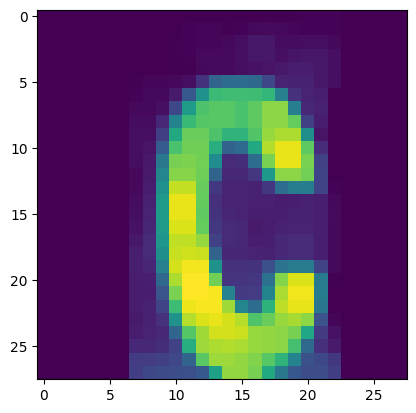

0.85882354
(1, 28, 28) 1.png
1/1 [==============================] - 0s 229ms/step
Predicted ID=12
(28, 28)


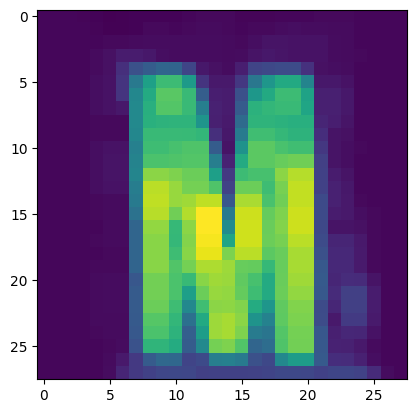

0.9098039
(1, 28, 28) 2.png
1/1 [==============================] - 0s 22ms/step
Predicted ID=30
(28, 28)


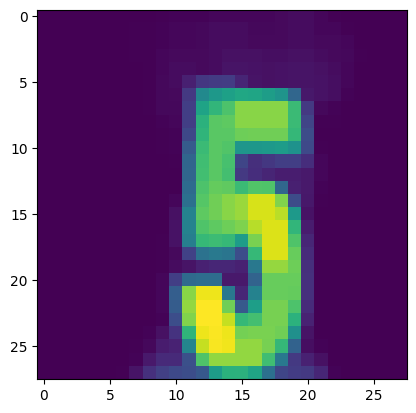

0.84313726
(1, 28, 28) 3.png
1/1 [==============================] - 0s 20ms/step
Predicted ID=5
(28, 28)


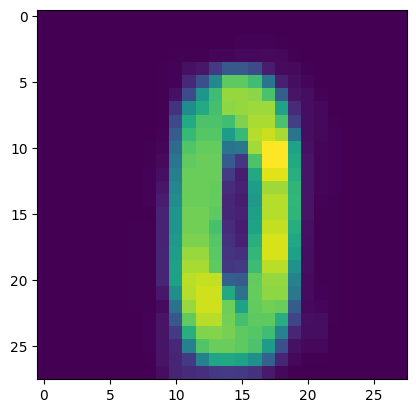

0.8862745
(1, 28, 28) 4.png
1/1 [==============================] - 0s 24ms/step
Predicted ID=18
(28, 28)


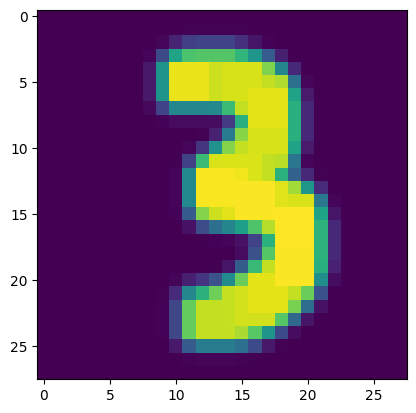

0.85882354
(1, 28, 28) Test.png
1/1 [==============================] - 0s 22ms/step
Predicted ID=3


In [6]:
import numpy as np
import cv2
from os import walk
def checkImage(im,name):


    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((2, 2), 'uint8')
    #Нужно немного дилатации чтоб ~ лучше соответствовало EMNIST
    im = cv2.dilate(im, kernel, iterations=2)
    
    im=cv2.resize(im,(28,28))
    print(im.shape)
    im=im.astype('float32')/255.0
    
    im=im.reshape((1,28,28))

    from matplotlib import pyplot as plt
    plt.imshow((im).reshape((28,28)), interpolation='nearest')
    plt.show()
    
    print(im.max().max())
    
    print(str(im.shape),name)
    #print(model.predict(x_test,batch_size=1).argmax())
    print("Predicted ID="+str(model.predict(im,batch_size=1).argmax()))
    



def WorkAllImages(folderPath):
    print(folderPath)
    for (dirpath, dirnames, filenames) in walk(folderPath):
        #f.extend(filenames)
        print(dirpath,dirnames,filenames)
        
        for image in filenames:
            im = cv2.imread(dirpath+image)
            
            checkImage(im,image)

model.evaluate(x_test,y_test)
WorkAllImages("./Prepared/")